# Encoder-Decoder Model with Attention: Bidirectional LSTM & Fasttext Embedding
# (Word Level)

## Loading Libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
import re
import datetime
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import nltk.translate.bleu_score as bleu
import tensorflow as tf
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM, Flatten, Activation, Bidirectional, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading Dataset

In [ ]:
data_path = '/content/drive/MyDrive/CS2/2.Datasets/'
model_path = '/content/drive/MyDrive/CS2/3.Models/4_5_Attention-Bi-Word-Fasttext/'

In [ ]:
data = pd.read_csv(data_path + 'final_data.csv')
print(data.shape)
data.head()

(101717, 2)


,input_text,output_text
0,"Ofcouse , I love cheap fashion , fast fashion ...","Of course , I love cheap , fast fashion like f..."
1,If he want to listen to music that I do n't li...,If he wants to listen to music that I do n't l...
2,This happened because of the cultural differen...,This happened because of the cultural differen...
3,I 'm gon na earn much money to study abroad .,I 'm gon na earn enough money to study abroad .
4,It is not difficult for me but answer phones a...,It is not difficult for me but answering the p...


## Preprocess Data

In [ ]:
def clean(text):
    text = re.sub('<.*>', '', text)
    text = re.sub('\(.*\)', '', text)
    text = re.sub('\[.*\]', '', text)
    text = re.sub('{.*}', '', text)
    text = re.sub("[-+@#^/|*(){}$~`<>=_]","",text)
    text = text.replace("\\","")
    text = re.sub("\[","",text)
    text = re.sub("\]","",text)
    text = re.sub("[0-9]","",text)
    return text

data['input_text'] = data['input_text'].apply(lambda x: clean(x))
data['output_text'] = data['output_text'].apply(lambda x: clean(x))

In [ ]:
def preprocessing(data):
   
    data['input_text_length'] = data['input_text'].str.split().apply(len)
    data['output_text_length'] = data['output_text'].str.split().apply(len)

    data = data[data['input_text_length'] < 25]
    data = data[data['output_text_length'] < 25]

    data['output_text_in'] = '<start> ' + data['output_text'].astype(str)
    data['output_text_out'] = data['output_text'].astype(str) + ' <end>'

    data = data.drop(['input_text_length','output_text_length','output_text'], axis=1)
    return data

In [ ]:
data = preprocessing(data)

data.iloc[0]['output_text_in'] = str(data.iloc[0]['output_text_in'])+' <end>'
data.iloc[0]['output_text_out'] = str(data.iloc[0]['output_text_out'])+' <end>'

print('Shape of Dataset:', data.shape)
data.head()

Shape of Dataset: (93503, 3)


,input_text,output_text_in,output_text_out
0,"Ofcouse , I love cheap fashion , fast fashion ...","<start> Of course , I love cheap , fast fashio...","Of course , I love cheap , fast fashion like f..."
1,If he want to listen to music that I do n't li...,<start> If he wants to listen to music that I ...,If he wants to listen to music that I do n't l...
2,This happened because of the cultural differen...,<start> This happened because of the cultural ...,This happened because of the cultural differen...
3,I 'm gon na earn much money to study abroad .,<start> I 'm gon na earn enough money to study...,I 'm gon na earn enough money to study abroad ...
4,It is not difficult for me but answer phones a...,<start> It is not difficult for me but answeri...,It is not difficult for me but answering the p...


## Train Test Split

In [ ]:
train, test = train_test_split(data, test_size=0.1, random_state=42)
print('Shape of Train Data:', train.shape)
print('Shape of Test Data:', test.shape)

Shape of Train Data: (84152, 3)
Shape of Test Data: (9351, 3)


## Tokenization

In [ ]:
tokenizer_i = Tokenizer(filters="", char_level=False, lower=False)
tokenizer_o = Tokenizer(filters="", char_level=False, lower=False)

tokenizer_i.fit_on_texts(train['input_text'].values)
tokenizer_o.fit_on_texts(train['output_text_in'].values)

vocab_size_input = len(tokenizer_i.word_index.keys())
print('Input Vocab Size:', vocab_size_input)

vocab_size_output = len(tokenizer_o.word_index.keys())
print('Output Vocab Size:', vocab_size_output)

Input Vocab Size: 35510
Output Vocab Size: 29350


In [ ]:
input_vocab = tokenizer_i.word_index
output_vocab = tokenizer_o.word_index

## Fasttext Embedding

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip

--2021-08-11 11:14:04--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  20.9MB/s    in 32s     

2021-08-11 11:14:37 (20.5 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('wiki-news-300d-1M.vec') 
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded word vectors =', len(embeddings_index))

# create a weight matrix for words in training docs
encoder_embedding_matrix_fast = np.zeros((len(input_vocab)+1, 300))
for word, i in input_vocab.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		encoder_embedding_matrix_fast[i] = embedding_vector
print('Shape of Encoder Embedding Matrix =', encoder_embedding_matrix_fast.shape)

# create a weight matrix for words in training docs
decoder_embedding_matrix_fast = np.zeros((len(output_vocab)+1, 300))
for word, i in output_vocab.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		decoder_embedding_matrix_fast[i] = embedding_vector
print('Shape of Decoder Embedding Matrix =', decoder_embedding_matrix_fast.shape)

Loaded word vectors = 999995
Shape of Encoder Embedding Matrix = (35511, 300)
Shape of Decoder Embedding Matrix = (29351, 300)


## Data Pipeline

In [ ]:
class Dataset:
    def __init__(self, data, tokenizer_i, tokenizer_o, max_len_enc, max_len_dec):
        self.encoder_inps = data['input_text'].values
        self.decoder_inps = data['output_text_in'].values
        self.decoder_outs = data['output_text_out'].values
        self.tokenizer_o = tokenizer_o
        self.tokenizer_i = tokenizer_i
        self.max_len_enc = max_len_enc
        self.max_len_dec = max_len_dec


    def __getitem__(self, i):
        self.encoder_seq = self.tokenizer_i.texts_to_sequences([self.encoder_inps[i]]) 
        self.decoder_inp_seq = self.tokenizer_o.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tokenizer_o.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len_enc, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len_dec, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len_dec, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self):
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self): 
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
train_dataset = Dataset(train, tokenizer_i, tokenizer_o, 25, 25)
test_dataset  = Dataset(test, tokenizer_i, tokenizer_o, 25, 25)

train_dataloader = Dataloder(train_dataset, batch_size=512)
test_dataloader = Dataloder(test_dataset, batch_size=512)

print('Train Dataloader:', train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)
print('Test Dataloader:', test_dataloader[0][0][0].shape, test_dataloader[0][0][1].shape, test_dataloader[0][1].shape)

Train Dataloader: (512, 25) (512, 25) (512, 25)
Test Dataloader: (512, 25) (512, 25) (512, 25)


## Model Building

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''
    def __init__(self,in_vocab_size,embedding_dim,enc_units,input_length):
        super().__init__()
        self.in_vocab_size = in_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.enc_units = enc_units

    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.in_vocab_size, output_dim=self.embedding_dim, input_length=self.input_length, mask_zero=True, weights=[encoder_embedding_matrix_fast], trainable=False, name="Encoder_Embedding")
        self.lstm = Bidirectional(LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM"))
        
    def call(self, input_sentences, training=True):
        input_embed = self.embedding(input_sentences)
        encoder_output, encoder_state_h_fwd, encoder_state_c_fwd, encoder_state_h_bwd, encoder_state_c_bwd = self.lstm(input_embed)
        encoder_state_h = Concatenate()([encoder_state_h_fwd, encoder_state_h_bwd])
        encoder_state_c = Concatenate()([encoder_state_c_fwd, encoder_state_c_bwd])
        return encoder_output, encoder_state_h, encoder_state_c

#-----------------------------------------------------------------------------------------------------------------------------------
class Attention(tf.keras.layers.Layer):
  '''
  Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super().__init__()
    self.scoring_function = scoring_function
    self.att_units = att_units

    if self.scoring_function == 'dot':
      pass

    if scoring_function == 'general':
      self.W = Dense(self.att_units)
      
    elif scoring_function == 'concat':
      self.W1 = Dense(self.att_units)
      self.W2 = Dense(self.att_units)
      self.Va = Dense(1)
  
  
  def call(self,decoder_hidden_state,encoder_output):
    if self.scoring_function == 'dot':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 2)
        score = tf.matmul(encoder_output, decoder_hidden_state)

    elif self.scoring_function == 'general':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 2)
        score = tf.matmul(self.W(encoder_output), decoder_hidden_state)

    elif self.scoring_function == 'concat':
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        score = self.Va(tf.nn.tanh(self.W1(decoder_hidden_state) + self.W2(encoder_output)))

    attention_weight = tf.nn.softmax(score, axis=1)
    context_vector = tf.reduce_sum(attention_weight * encoder_output, axis=1)
    return context_vector, attention_weight

#-----------------------------------------------------------------------------------------------------------------------------------
class One_Step_Decoder(tf.keras.Model):
  def __init__(self, tar_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units):
      super().__init__()
      self.tar_vocab_size = tar_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units= dec_units
      self.score_fun = score_fun
      self.att_units = att_units

  def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.tar_vocab_size, output_dim=self.embedding_dim, input_length=self.input_length, mask_zero=True, weights=[decoder_embedding_matrix_fast], trainable=False, name="Decoder_Embedding")
        self.lstm = LSTM(self.dec_units*2, return_state=True, return_sequences=True, name="Decoder_LSTM")
        self.dense = Dense(self.tar_vocab_size)
        self.attention = Attention(self.score_fun, self.att_units)

  def call(self,input_to_decoder, encoder_output, state_h, state_c):
    
    target_embedd = self.embedding(input_to_decoder)

    context_vector, attention_weights = self.attention(state_h, encoder_output)
    context_vector = tf.expand_dims(context_vector, 1)

    decoder_input = tf.concat([target_embedd, context_vector], 2)

    decoder_output, decoder_final_state_h, decoder_final_state_c = self.lstm(decoder_input, initial_state=[state_h,state_c])

    output = self.dense(decoder_output)

    return tf.squeeze(output), decoder_final_state_h, decoder_final_state_c, attention_weights, tf.squeeze(context_vector)

#-----------------------------------------------------------------------------------------------------------------------------------
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun, att_units):
      super(Decoder, self).__init__()
      self.out_vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.score_fun = score_fun
      self.att_units = att_units
      self.one_step_decoder = One_Step_Decoder(self.out_vocab_size, self.embedding_dim, self.input_length, self.dec_units, self.score_fun, self.att_units)

   
    def call(self, input_to_decoder, encoder_output_state, decoder_hidden_state, decoder_cell_state):
      all_outputs = tf.TensorArray(tf.float32, size=tf.shape(input_to_decoder)[1], name="output_arrays")

      for timestep in range(tf.shape(input_to_decoder)[1]):
        output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = self.one_step_decoder(input_to_decoder[:,timestep:timestep+1], encoder_output_state, decoder_hidden_state, decoder_cell_state)
        all_outputs = all_outputs.write(timestep, output)

      all_outputs = tf.transpose(all_outputs.stack(), [1, 0, 2])
      return all_outputs

#-----------------------------------------------------------------------------------------------------------------------------------
class Encoder_Decoder(tf.keras.Model):
  def __init__(self, encoder_inputs_length, decoder_inputs_length, input_vocab_size, output_vocab_size, embedding_dim, enc_units, dec_units, att_units, batch_size, score_fun, name='Encoder-Decoder-Attention'):
    super().__init__(name=name)
    self.encoder = Encoder(in_vocab_size=input_vocab_size+1, embedding_dim=embedding_dim, enc_units=enc_units, input_length=encoder_inputs_length)
    self.decoder = Decoder(out_vocab_size=output_vocab_size+1, embedding_dim=embedding_dim, input_length=decoder_inputs_length, dec_units=dec_units, score_fun=score_fun, att_units=att_units)
    self.batch_size = batch_size

  def call(self,data):

    input, output = data[0], data[1]

    encoder_output, encoder_h, encoder_c = self.encoder(input)
    decoder_output = self.decoder(output, encoder_output, encoder_h, encoder_c)
    return decoder_output

## Custom Loss Function

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

## Model Training

In [ ]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.99, patience=100)
es = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1, min_delta=0.001, monitor='val_loss', mode='min', restore_best_weights=True)

train_steps = train.shape[0]//512
valid_steps = test.shape[0]//512

model  = Encoder_Decoder(encoder_inputs_length=25,
                          decoder_inputs_length=25,
                          input_vocab_size=vocab_size_input,
                          output_vocab_size=vocab_size_output, 
                          embedding_dim=300, 
                          enc_units=256, 
                          dec_units=256, 
                          att_units=256,
                          batch_size=512,
                          score_fun='dot')

model.compile(optimizer=tf.keras.optimizers.Adam(),loss=loss_function)

20 Epoch

In [ ]:
with tf.device('/device:GPU:0'):
    history20 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/20
164/164 [==============================] - 185s 1s/step - loss: 3.1284 - val_loss: 2.8971
Epoch 2/20
164/164 [==============================] - 176s 1s/step - loss: 2.8400 - val_loss: 2.7338
Epoch 3/20
164/164 [==============================] - 179s 1s/step - loss: 2.6552 - val_loss: 2.5243
Epoch 4/20
164/164 [==============================] - 180s 1s/step - loss: 2.4050 - val_loss: 2.2326
Epoch 5/20
164/164 [==============================] - 180s 1s/step - loss: 2.1016 - val_loss: 1.9391
Epoch 6/20
164/164 [==============================] - 180s 1s/step - loss: 1.8365 - val_loss: 1.6782
Epoch 7/20
164/164 [==============================] - 180s 1s/step - loss: 1.5743 - val_loss: 1.4253
Epoch 8/20
164/164 [==============================] - 180s 1s/step - loss: 1.3487 - val_loss: 1.2280
Epoch 9/20
164/164 [==============================] - 180s 1s/step - loss: 1.1847 - val_loss: 1.0900
Epoch 10/20
164/164 [==============================] - 180s 1s/step - loss: 1.0615 - val_lo

In [ ]:
model.save_weights(model_path + 'att20/' + 'attention20', save_format='tf') 

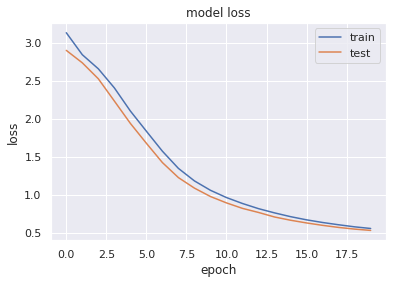

In [ ]:
plt.plot(history20.history['loss'])
plt.plot(history20.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
model.summary()

Model: "Encoder-Decoder-Attention"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  11794036  
_________________________________________________________________
decoder (Decoder)            multiple                  26575963  
Total params: 38,369,999
Trainable params: 18,911,399
Non-trainable params: 19,458,600
_________________________________________________________________


40 Epoch

In [ ]:
with tf.device('/device:GPU:0'): 
    history40 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=20, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/20
164/164 [==============================] - 181s 1s/step - loss: 0.5404 - val_loss: 0.5158
Epoch 2/20
164/164 [==============================] - 180s 1s/step - loss: 0.5392 - val_loss: 0.5087
Epoch 3/20
164/164 [==============================] - 181s 1s/step - loss: 0.5101 - val_loss: 0.4832
Epoch 4/20
164/164 [==============================] - 180s 1s/step - loss: 0.4923 - val_loss: 0.4730
Epoch 5/20
164/164 [==============================] - 181s 1s/step - loss: 0.4793 - val_loss: 0.4553
Epoch 6/20
164/164 [==============================] - 181s 1s/step - loss: 0.4630 - val_loss: 0.4467
Epoch 7/20
164/164 [==============================] - 180s 1s/step - loss: 0.4509 - val_loss: 0.4296
Epoch 8/20
164/164 [==============================] - 180s 1s/step - loss: 0.4416 - val_loss: 0.4211
Epoch 9/20
164/164 [==============================] - 180s 1s/step - loss: 0.4281 - val_loss: 0.4069
Epoch 10/20
164/164 [==============================] - 180s 1s/step - loss: 0.4566 - val_lo

In [ ]:
model.save_weights(model_path + 'att40/' + 'attention40', save_format='tf') 

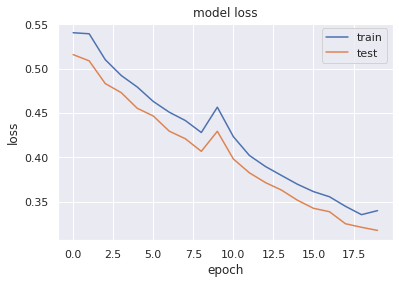

In [ ]:
plt.plot(history40.history['loss'])
plt.plot(history40.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

50 Epoch

In [ ]:
with tf.device('/device:GPU:0'): 
    history50 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/10
164/164 [==============================] - 181s 1s/step - loss: 0.3272 - val_loss: 0.3058
Epoch 2/10
164/164 [==============================] - 181s 1s/step - loss: 0.3124 - val_loss: 0.2929
Epoch 3/10
164/164 [==============================] - 180s 1s/step - loss: 0.3026 - val_loss: 0.2865
Epoch 4/10
164/164 [==============================] - 181s 1s/step - loss: 0.2955 - val_loss: 0.2784
Epoch 5/10
164/164 [==============================] - 181s 1s/step - loss: 0.2882 - val_loss: 0.2734
Epoch 6/10
164/164 [==============================] - 181s 1s/step - loss: 0.2812 - val_loss: 0.2656
Epoch 7/10
164/164 [==============================] - 181s 1s/step - loss: 0.2729 - val_loss: 0.2585
Epoch 8/10
164/164 [==============================] - 181s 1s/step - loss: 0.2653 - val_loss: 0.2487
Epoch 9/10
164/164 [==============================] - 180s 1s/step - loss: 0.2590 - val_loss: 0.2455
Epoch 10/10
164/164 [==============================] - 215s 1s/step - loss: 0.2515 - val_lo

In [ ]:
model.save_weights(model_path + 'att50/' + 'attention50', save_format='tf') 

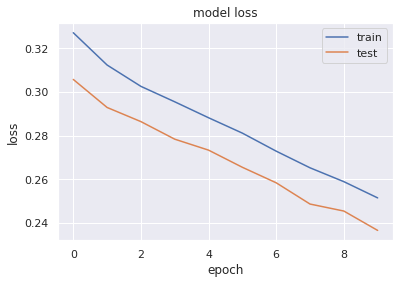

In [ ]:
plt.plot(history50.history['loss'])
plt.plot(history50.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

60 Epoch

In [ ]:
with tf.device('/device:GPU:0'): 
    history60 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/10
164/164 [==============================] - 181s 1s/step - loss: 0.2453 - val_loss: 0.2327
Epoch 2/10
164/164 [==============================] - 181s 1s/step - loss: 0.2388 - val_loss: 0.2227
Epoch 3/10
164/164 [==============================] - 181s 1s/step - loss: 0.2385 - val_loss: 0.2332
Epoch 4/10
164/164 [==============================] - 181s 1s/step - loss: 0.2282 - val_loss: 0.2082
Epoch 5/10
164/164 [==============================] - 181s 1s/step - loss: 0.2277 - val_loss: 0.2079
Epoch 6/10
164/164 [==============================] - 181s 1s/step - loss: 0.2158 - val_loss: 0.1991
Epoch 7/10
164/164 [==============================] - 179s 1s/step - loss: 0.2045 - val_loss: 0.1905
Epoch 8/10
164/164 [==============================] - 180s 1s/step - loss: 0.1969 - val_loss: 0.1830
Epoch 9/10
164/164 [==============================] - 180s 1s/step - loss: 0.1917 - val_loss: 0.1823
Epoch 10/10
164/164 [==============================] - 181s 1s/step - loss: 0.1867 - val_lo

In [ ]:
model.save_weights(model_path + 'att60/' + 'attention60', save_format='tf') 

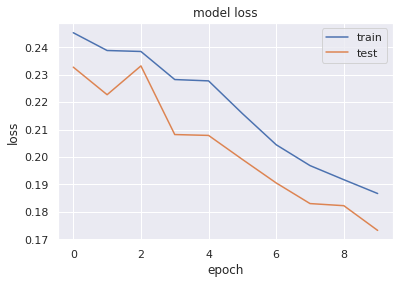

In [ ]:
plt.plot(history60.history['loss'])
plt.plot(history60.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

70 Epoch

In [ ]:
with tf.device('/device:GPU:0'): 
    history70 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/10
164/164 [==============================] - 198s 1s/step - loss: 0.1897 - val_loss: 0.1769
Epoch 2/10
164/164 [==============================] - 183s 1s/step - loss: 0.2136 - val_loss: 0.1908
Epoch 3/10
164/164 [==============================] - 183s 1s/step - loss: 0.1821 - val_loss: 0.1616
Epoch 4/10
164/164 [==============================] - 184s 1s/step - loss: 0.1651 - val_loss: 0.1551
Epoch 5/10
164/164 [==============================] - 182s 1s/step - loss: 0.1659 - val_loss: 0.1520
Epoch 6/10
164/164 [==============================] - 182s 1s/step - loss: 0.1535 - val_loss: 0.1407
Epoch 7/10
164/164 [==============================] - 182s 1s/step - loss: 0.1469 - val_loss: 0.1347
Epoch 8/10
164/164 [==============================] - 182s 1s/step - loss: 0.1399 - val_loss: 0.1289
Epoch 9/10
164/164 [==============================] - 182s 1s/step - loss: 0.1401 - val_loss: 0.1278
Epoch 10/10
164/164 [==============================] - 182s 1s/step - loss: 0.1333 - val_lo

In [ ]:
model.save_weights(model_path + 'att70/' + 'attention70', save_format='tf') 

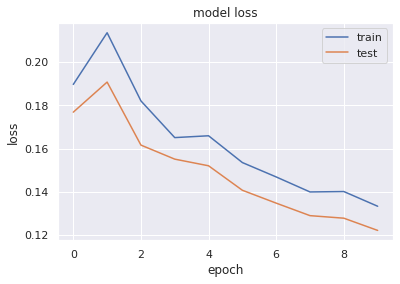

In [ ]:
plt.plot(history70.history['loss'])
plt.plot(history70.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

80 Epoch

In [ ]:
with tf.device('/device:GPU:0'): 
    history80 = model.fit_generator(train_dataloader, steps_per_epoch=train_steps, epochs=10, validation_data=train_dataloader, validation_steps=train_steps, callbacks=[lr,es])

Epoch 1/10
164/164 [==============================] - 183s 1s/step - loss: 0.1516 - val_loss: 0.1263
Epoch 2/10
164/164 [==============================] - 183s 1s/step - loss: 0.1303 - val_loss: 0.1136
Epoch 3/10
164/164 [==============================] - 183s 1s/step - loss: 0.1178 - val_loss: 0.1070
Epoch 4/10
164/164 [==============================] - 183s 1s/step - loss: 0.1121 - val_loss: 0.1025
Epoch 5/10
164/164 [==============================] - 182s 1s/step - loss: 0.1076 - val_loss: 0.1012
Epoch 6/10
164/164 [==============================] - 183s 1s/step - loss: 0.2603 - val_loss: 0.1952
Epoch 7/10
164/164 [==============================] - 182s 1s/step - loss: 0.1687 - val_loss: 0.1294
Epoch 8/10
164/164 [==============================] - 182s 1s/step - loss: 0.1259 - val_loss: 0.1063
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping


In [ ]:
model.save_weights(model_path + 'att80/' + 'attention80', save_format='tf') 

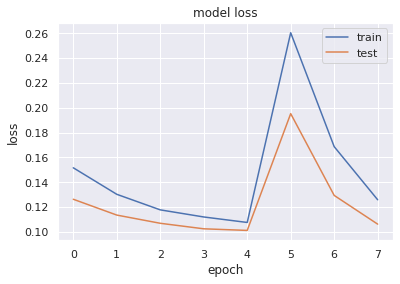

In [ ]:
plt.plot(history80.history['loss'])
plt.plot(history80.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Model Prediction

In [ ]:
def predict(input_sentence):

  batch_size = 1 
  DECODER_SEQ_LEN = 25
  predict_word_idx = np.zeros((1, 1))
  predict_word_idx[0,0] = 1
  predicted_sentence = ''

  input_sequence=tokenizer_i.texts_to_sequences([input_sentence])
  inputs=pad_sequences(input_sequence,maxlen=25,padding='post')
  inputs=tf.convert_to_tensor(inputs)

  enc_output, state_h, state_c = model.layers[0](inputs)

  for i in range(DECODER_SEQ_LEN):
      dec_output, state_h, state_c, attention_weights, context_vector = model.layers[1].one_step_decoder(predict_word_idx, enc_output, state_h, state_c)
      predict_word_idx = np.reshape(np.argmax(dec_output), (1, 1))
      predicted_sentence += ' ' + tokenizer_o.index_word[int(predict_word_idx)]

      if tokenizer_o.word_index['<end>'] == predict_word_idx:
          return predicted_sentence
      dec_input = tf.expand_dims([predict_word_idx],0)
  return predicted_sentence

#----------------------------------------------------------------------------------------------------
import nltk.translate.bleu_score as bleu

def get_BLEU(model, train, test):
    total_bleu=0
    input_range = 100
    for i in range(0,input_range):
        output_sentence = ' '.join(train['output_text_out'].iloc[i].split()[:-1])
        predicted_sentence = ' '.join(predict(train['input_text'].iloc[i]).split()[:-1])
        output_sentence = [output_sentence.split()]
        predicted_sentence = predicted_sentence.split()
        bleu_score = bleu.sentence_bleu(output_sentence, predicted_sentence)
        total_bleu += bleu_score
    train_avg_bleu = total_bleu/input_range

    total_bleu=0
    input_range = 100
    for i in range(0,input_range):
        output_sentence = ' '.join(test['output_text_out'].iloc[i].split()[:-1])
        predicted_sentence = ' '.join(predict(test['input_text'].iloc[i]).split()[:-1])
        output_sentence = [output_sentence.split()]
        predicted_sentence = predicted_sentence.split()
        bleu_score = bleu.sentence_bleu(output_sentence, predicted_sentence)
        total_bleu += bleu_score
    test_avg_bleu = total_bleu/input_range

    print('Train BLEU Score:', train_avg_bleu)
    print('Test BLEU Score:', test_avg_bleu)

In [ ]:
print('SUMMARY OF AVERAGE BLEU SCORE AT EPOCHS')
print('-'*50)

print('Epoch 20')
model.load_weights(model_path + 'att20/' + 'attention20')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 40')
model.load_weights(model_path + 'att40/' + 'attention40')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 50')
model.load_weights(model_path + 'att50/' + 'attention50')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 60')
model.load_weights(model_path + 'att60/' + 'attention60')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 70')
model.load_weights(model_path + 'att70/' + 'attention70')
get_BLEU(model, train, test)
print('='*50)

print('Epoch 80')
model.load_weights(model_path + 'att80/' + 'attention80')
get_BLEU(model, train, test)
print('='*50)

SUMMARY OF AVERAGE BLEU SCORE AT EPOCHS
--------------------------------------------------
Epoch 20
Train BLEU Score: 0.5977507594441497
Test BLEU Score: 0.5272503142879935
Epoch 40
Train BLEU Score: 0.6531866895704914
Test BLEU Score: 0.5364951870842876
Epoch 50
Train BLEU Score: 0.6990811048274511
Test BLEU Score: 0.5288988522961307
Epoch 60
Train BLEU Score: 0.7337227482270912
Test BLEU Score: 0.5107392055893459
Epoch 70
Train BLEU Score: 0.7974770521009844
Test BLEU Score: 0.5122925014452935
Epoch 80
Train BLEU Score: 0.8401762114031729
Test BLEU Score: 0.5047640179793668


In [ ]:
model.load_weights(model_path + 'att50/' + 'attention50')

Train

In [ ]:
for i in range(len(train[:5])):
    print("Input Text:", train['input_text'].iloc[i])
    print("Output Text:", ' '.join(train['output_text_out'].iloc[i].split()[:-1]))
    print("Predicted Text:", ' '.join(predict(train['input_text'].iloc[i]).split()[:-1]))
    print('='*100)

Input Text: At the party , the member has variety job .
Output Text: At the party , the members have a variety of jobs .
Predicted Text: At the party , the members have a variety of jobs .
Input Text: Thank you NY .
Output Text: Thank you , NY !
Predicted Text: Thank you , NY .
Input Text: Few last days have been strange .
Output Text: The last few days have been strange .
Predicted Text: A few days have been strange .
Input Text: I 've started feeling lately that I have n't figured out what kind of relationships I 'm seeking for with people around me .
Output Text: I 've started feeling lately that I have n't figured out what kind of relationships I 'm seeking with the people around me .
Predicted Text: I 've started feeling lately that I have n't figured out what kind of relationships I 'm seeking forward to the people around me
Input Text: We also often listen to the CD which includes the conversation amongst native speakers .
Output Text: We also often listened to the CD which incl

Test

In [ ]:
for i in range(len(test[:5])):
    print("Input Text:", test['input_text'].iloc[i])
    print("Output Text:", ' '.join(test['output_text_out'].iloc[i].split()[:-1]))
    print("Predicted Text:", ' '.join(predict(test['input_text'].iloc[i]).split()[:-1]))
    print('='*100)

Input Text: Have you ever over the wall of school ?
Output Text: Have you ever climbed over the wall at school ?
Predicted Text: Have you ever over the wall of school ?
Input Text: It is so narrow that I have to keep my body very fit everytime .
Output Text: It is so narrow that I have to keep my body very fit all the time .
Predicted Text: It is so narrow that I have to keep my body very strong .
Input Text: You can check the maintenance is finished or not at twitter .
Output Text: You can check whether the maintenance is finished or not on twitter .
Predicted Text: You can check the maintenance is finished or not on Twitter .
Input Text: Anyone who gets higher than  scores can pass it .
Output Text: Anyone who gets higher than a , passes it or passes the exam .
Predicted Text: Anyone who gets higher than score can pass it .
Input Text: I talked with Rie about our job , but it was a short time .
Output Text: I talked with Rie about our job , but it was just for a short time .
Predicte